In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_global_dataframes import modulation_cycle_signal_concat_job
from bibliotheque import get_pos, init_nan_da, df_baseline, get_df_mask_chan_signif, keep_clean, cluster_stats
import mne
import os
from configuration import base_folder
from params import *
import ghibtools as gh
import scipy

In [2]:
mask_params = dict(markersize=15, markerfacecolor='y')

In [3]:
indexes = ['participant','session','chan']
metrics = ['amplitude']
metrics_with_psycho = ['amplitude','stai_state','stai_trait','Maia_Mean']

In [4]:
modulation = modulation_cycle_signal_concat_job.get(global_key).to_dataframe()
modulation = keep_clean(df_raw = modulation, metrics_to_clean = metrics)
modulation = modulation.iloc[:,1:]

In [5]:
modulation

,participant,session,chan,amplitude,stai_state,stai_trait,keep_session,Gender,Maia_Mean,OAS,BMRQ
0,P01,baseline,Fp1,0.000002,40,61,1,F,1.019643,2.666667,2.727273
1,P01,baseline,Fz,0.000002,40,61,1,F,1.019643,2.666667,2.727273
2,P01,baseline,F3,0.000003,40,61,1,F,1.019643,2.666667,2.727273
3,P01,baseline,F7,0.000005,40,61,1,F,1.019643,2.666667,2.727273
4,P01,baseline,FT9,0.000006,40,61,1,F,1.019643,2.666667,2.727273
...,...,...,...,...,...,...,...,...,...,...,...
2785,P31,odor,FC6,0.000006,29,40,1,M,2.790774,2.933333,2.681818
2786,P31,odor,FC2,0.000004,29,40,1,M,2.790774,2.933333,2.681818
2787,P31,odor,F4,0.000007,29,40,1,M,2.790774,2.933333,2.681818
2788,P31,odor,F8,0.000007,29,40,1,M,2.790774,2.933333,2.681818


In [6]:
modulation['keep_session'].value_counts()

keep_session
1    2697
0      93
Name: count, dtype: int64

<AxesSubplot: >

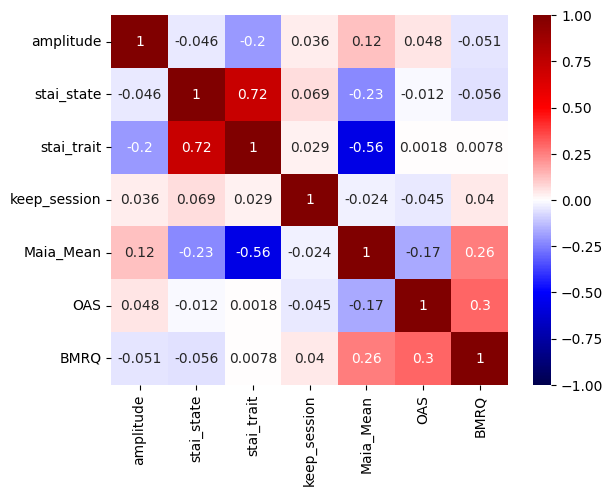

In [7]:
sns.heatmap(modulation.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

In [8]:
modulation

,participant,session,chan,amplitude,stai_state,stai_trait,keep_session,Gender,Maia_Mean,OAS,BMRQ
0,P01,baseline,Fp1,0.000002,40,61,1,F,1.019643,2.666667,2.727273
1,P01,baseline,Fz,0.000002,40,61,1,F,1.019643,2.666667,2.727273
2,P01,baseline,F3,0.000003,40,61,1,F,1.019643,2.666667,2.727273
3,P01,baseline,F7,0.000005,40,61,1,F,1.019643,2.666667,2.727273
4,P01,baseline,FT9,0.000006,40,61,1,F,1.019643,2.666667,2.727273
...,...,...,...,...,...,...,...,...,...,...,...
2785,P31,odor,FC6,0.000006,29,40,1,M,2.790774,2.933333,2.681818
2786,P31,odor,FC2,0.000004,29,40,1,M,2.790774,2.933333,2.681818
2787,P31,odor,F4,0.000007,29,40,1,M,2.790774,2.933333,2.681818
2788,P31,odor,F8,0.000007,29,40,1,M,2.790774,2.933333,2.681818


In [9]:
modulation_baselined = df_baseline(df = modulation, indexes = indexes, metrics= metrics, mode = 'ratio')

In [10]:
modulation_baselined

,participant,session,chan,amplitude
0,P01,odor,Fp1,1.297812
1,P01,odor,Fz,1.246406
2,P01,odor,F3,1.039571
3,P01,odor,F7,0.695761
4,P01,odor,FT9,0.768943
...,...,...,...,...
1855,P31,music,FC6,2.213367
1856,P31,music,FC2,1.538058
1857,P31,music,F4,1.911542
1858,P31,music,F8,1.853576


<AxesSubplot: xlabel='chan', ylabel='amplitude'>

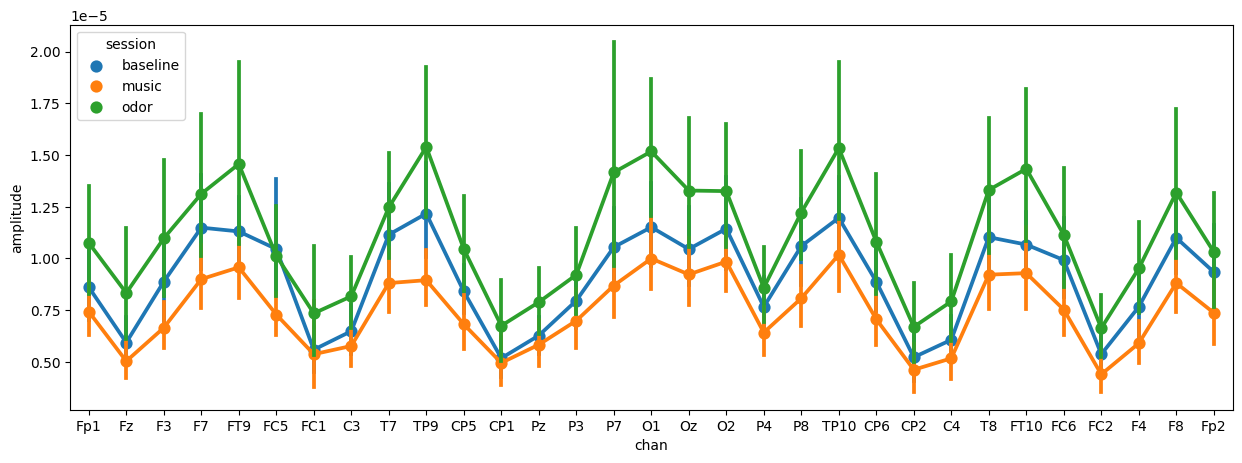

In [11]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = modulation, x = 'chan', y = 'amplitude', hue = 'session',ax=ax)

<AxesSubplot: xlabel='chan', ylabel='amplitude'>

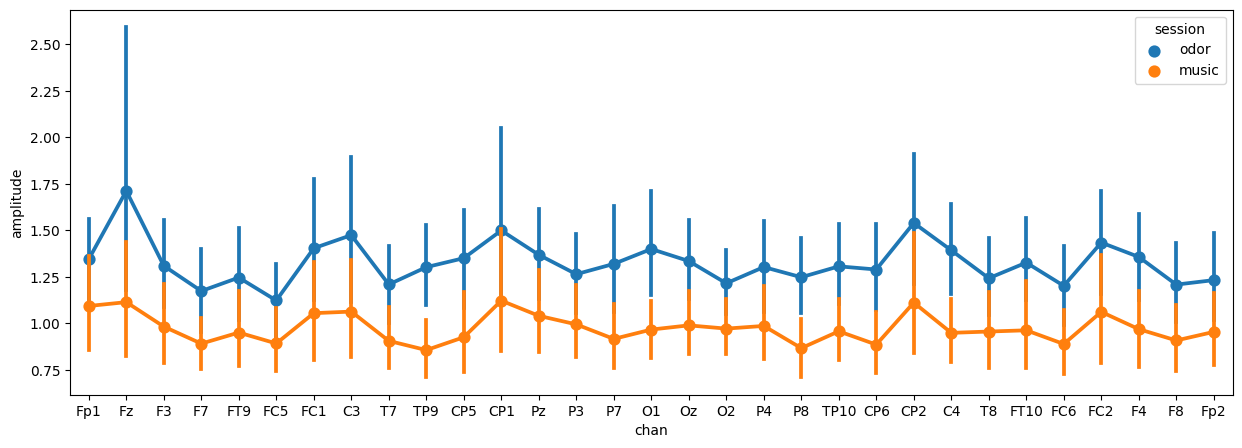

In [12]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = modulation_baselined, x = 'chan', y = 'amplitude', hue = 'session',ax=ax)

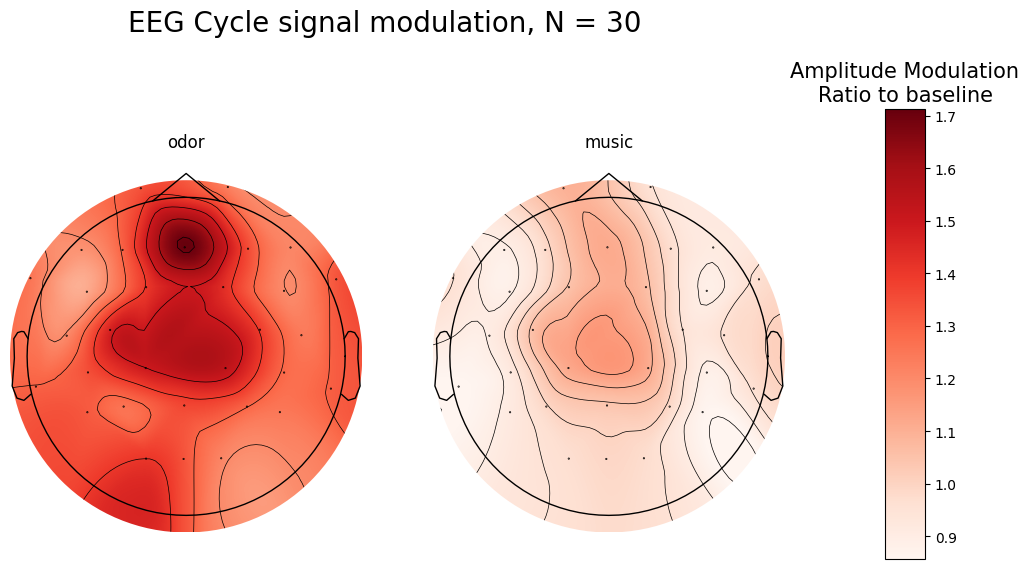

In [13]:
delta_quantile = 0.

colname = 'amplitude'

df = modulation_baselined

df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = colname, subject = 'participant')

N = modulation_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG Cycle signal modulation, N = {N}', fontsize = 20, y = 1.2)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Amplitude Modulation\nRatio to baseline',fontsize=15)

file = base_folder / 'Figures' / 'Cycle_Signal' / 'amplitude_modulation' / 'cycle_signal_all.png'

fig.savefig(file, bbox_inches = 'tight')

In [14]:
delta_quantile = 0.

colname = 'amplitude'

for subject in subject_keys:
    
    df = modulation_baselined[modulation_baselined['participant'] == subject]
    
    vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
    pos = get_pos()

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG Cycle Signal Modulation, sub = {subject}', fontsize = 20, y = 1.2)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Amplitude Modulation\nRatio to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'Cycle_Signal' / 'amplitude_modulation' / 'by_subject' / f'{subject}.png'

    fig.savefig(file, bbox_inches = 'tight')
    
    plt.close()

# STATS VS BASELINE

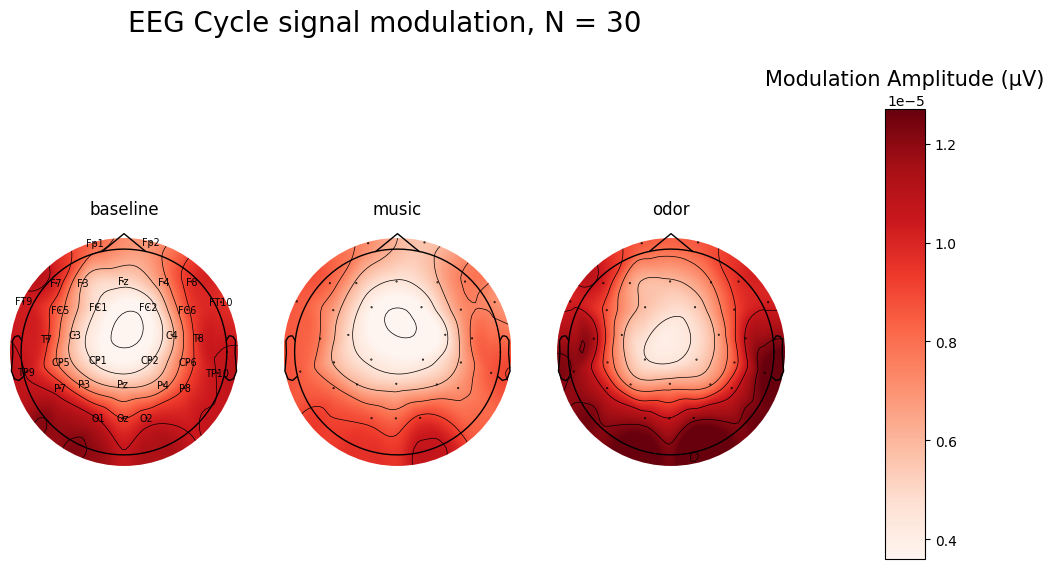

In [15]:
delta_quantile = 0.

metric = 'amplitude'

df = modulation.copy()

dfs_masks = []
for cond in ['odor','music']:
    df_to_mask = df[df['session'].isin(['baseline',cond])]
    df_mask = get_df_mask_chan_signif(df = df_to_mask, 
                                      chans = eeg_chans, 
                                      predictor = 'session', 
                                      outcome = metric, 
                                      subject = 'participant', 
                                      multicomp_method = 'bonf', 
                                      stats_type = 'permutations', 
                                      diff = 'median')
    df_mask['cond'] = cond
    dfs_masks.append(df_mask)
dfs_masks = pd.concat(dfs_masks)

N = modulation['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).median(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).median(numeric_only = True)[colname].values, 1 - delta_quantile)

# vmin = vmin if abs(vmin) > abs(vmax) else -vmax
# vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG Cycle signal modulation, N = {N}', fontsize = 20, y = 1.2)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    df_mask = dfs_masks[dfs_masks['cond'] == session]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(eeg_chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask.reindex(eeg_chans)['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Modulation Amplitude (µV)',fontsize=15)

file = base_folder / 'Figures' / 'Cycle_Signal' / 'amplitude_modulation' / 'cycle_signal_raw_stats_permutations.png'
fig.savefig(file, bbox_inches = 'tight')

[(array([3]),), (array([5]),), (array([9]),), (array([19]),), (array([21]),), (array([26]),), (array([29]),)] [0.16308594 0.25097656 0.11425781 0.19335938 0.22460938 0.22167969
 0.22949219]
[(array([9]),), (array([15]),), (array([20]),), (array([23]),), (array([25]),)] [0.27246094 0.1796875  0.203125   0.26269531 0.15917969]


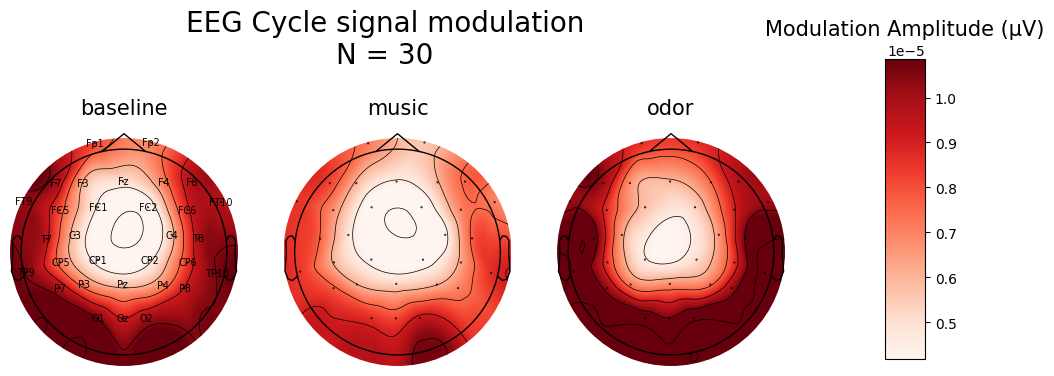

In [17]:
import xarray as xr
import ghibtools as gh

def cluster_stats(x1,x2, chans, verbose = True):
    X = x2 - x1
    t_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(X, out_type = 'indices', verbose = False)
    
    if verbose:
        print(clusters, cluster_p_values)

    mask_signif_chans = np.full(len(ch_names), False)

    chan_inds_signif = []
    for cluster, p  in zip(clusters, cluster_p_values):
        if p < 0.05:
            chan_inds_signif.extend(list(cluster[0]))
    mask_signif_chans[chan_inds_signif] = True
    return  mask_signif_chans

metric = 'amplitude'

ch_names = df['chan'].unique()
da = gh.init_da({'session':df['session'].unique(), 'participant':df['participant'].unique(), 'chan':ch_names})
for ses in da['session'].values:
    for participant in da['participant'].values:
        for chan in da['chan'].values:
            da.loc[ses,participant,chan] = df.set_index(['session','participant','chan']).loc[(ses,participant,chan),metric]

q_diff = 0.05

mask_params = dict(markersize=15, markerfacecolor='y')

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(1 - q_diff)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG Cycle signal modulation\nN = {N}', fontsize = 20, y = 1)

chans = da['chan'].values

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        x1 = da.sel(session = 'baseline').values
        x2 = da.sel(session = session).values
        mask = cluster_stats(x1,x2,chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = chans, axes = ax, show = False, vlim = (vmin,vmax), mask = mask, mask_params = mask_params)
    ax.set_title(f'{session}', fontsize = 15)
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.6
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Modulation Amplitude (µV)',fontsize=15)

fig.savefig(base_folder / 'Figures' / 'Cycle_Signal' / 'amplitude_modulation' / 'cycle_signal_cluster_stats.png', dpi = 300, bbox_inches = 'tight')

plt.show()